In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [3]:
import switch_detection_sweep_penalty_one_session as sdspos

In [4]:
row = subdb.iloc[1]

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
row

data_dir_full     /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...
sess_name                                           e15_13f1_220117
animal_name.1                                              e15_13f1
date                                                     2022-01-17
behavior                                                alternation
performance                                                0.617647
ntrials                                                          34
ngoodtrials                                                      34
n_neurons                                                       376
n_pyr_putative                                                  333
owner                                                         roman
data_root                                                roman_data
Name: (e15_13f1, 0), dtype: object

In [6]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
# pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
# fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
# occu_map_all = prepped_data_agg['occu_map_all']
# fr_map_all = prepped_data_agg['fr_map_all']

# pval_all = prepped_data_agg['pval_all']
# X_pwc_all = prepped_data_agg['X_pwc_all']
# X_raw_all = prepped_data_agg['X_raw_all']
# changes_df_all = prepped_data_agg['changes_df_all']
# var_res_all_test = prepped_data_agg['var_res_all']
# # corr_all = prepped_data_agg['corr_all']
# all_sw_d_all = prepped_data_agg['all_sw_d_all']
# all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
# best_n_all_test = prepped_data_agg['best_n_all']
# spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

# ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
# ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 
del prepped_data_agg


In [7]:
import glob
pen=0.5#0.3#0.3#0.5
data_dir_full = row['data_dir_full']
ani = row["animal_name.1"]
# ani = ind[0]
sess = row['sess_name']
sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
sw_res_pelt = sw_res_pelt[pen]

best_n=sw_res_pelt['best_n']
X_pwc=sw_res_pelt['X_pwc']
X_raw=sw_res_pelt['X_raw']
changes_df=sw_res_pelt['changes_df']
var_res=sw_res_pelt['var_res']
corr=sw_res_pelt['corr']
p_corr=sw_res_pelt['p_corr']

sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
if sw_info_res is None:
    sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)

all_sw_with_metrics = sw_info_res['all_sw_with_metrics_d']


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---


In [42]:
all_fields=all_fields_recombined_all.loc[(ani,sess),:]

/tmp/ipykernel_954591/3757556631.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields=all_fields_recombined_all.loc[(ani,sess),:]


In [8]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]


# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [9]:
index_within_to_trial_index_df=dpp.index_within_to_trial_index(spk_beh_df)

reload(pa)
cell_cols = cell_cols_d['pyr']
speed_thresh=0.5
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide','average'])
fr_map_d={k:val[0] for k,val in fr_map_dict.items()}
fr_map_df_all = pd.concat(fr_map_d,axis=0)

fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_all=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


gpb=fr_map_trial_df_all.groupby(level=(0,1),sort=False,group_keys=False)
fr_map_trial_df_all_=[]
for k,val in gpb:
    fr_map_trial_df_all_.append(val[index_within_to_trial_index_df.loc[k].index])
fr_map_trial_df_all_ = pd.concat(fr_map_trial_df_all_,axis=0)
fr_map_trial_df_all = fr_map_trial_df_all_


cell_cols = cell_cols_d['int']
speed_thresh=0.5
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide','average'])
fr_map_d={k:val[0] for k,val in fr_map_dict.items()}
fr_map_df_all_int = pd.concat(fr_map_d,axis=0)

fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_all_int=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)

gpb=fr_map_trial_df_all_int.groupby(level=(0,1),sort=False,group_keys=False)
fr_map_trial_df_all_int_=[]
for k,val in gpb:
    fr_map_trial_df_all_int_.append(val[index_within_to_trial_index_df.loc[k].index])
fr_map_trial_df_all_int_ = pd.concat(fr_map_trial_df_all_int_,axis=0)
fr_map_trial_df_all_int = fr_map_trial_df_all_int_


fr_map_trial_df_all_both=pd.concat([fr_map_trial_df_all_int,fr_map_trial_df_all],axis=0).sort_index(level=2)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [10]:
cell_cols = cell_cols_d['pyr']
speed_thresh=0.5
fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='task_index',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_bothtt_pyr=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_trial_d.keys()},axis=0)
fr_map_trial_df_bothtt_pyr = fr_map_trial_df_bothtt_pyr[index_within_to_trial_index_df.sort_values().values]


cell_cols = cell_cols_d['int']
speed_thresh=0.5
fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='task_index',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_bothtt_int=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_trial_d.keys()},axis=0)
fr_map_trial_df_bothtt_int=fr_map_trial_df_bothtt_int[index_within_to_trial_index_df.sort_values().values]

cant format into a dataframe
cant format into a dataframe


# find a beautiful pop up

In [11]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

<Axes: >

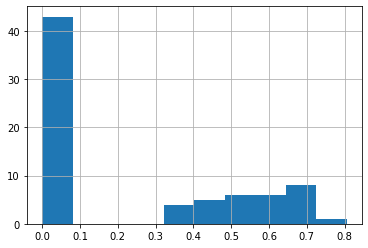

In [30]:
per_field_metrics_one.loc['both']['fit_var_ratio'].hist()

/tmp/ipykernel_954591/1454709733.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess,ti),:]


(<Figure size 576x864 with 5 Axes>,
 array([<Axes: >,
        <Axes: title={'center': 'cell 195 field 0'}, xlabel='Trial', ylabel='Mean selected Int. FR'>,
        <Axes: xlabel='Trial', ylabel='Mean Int. FR'>], dtype=object))

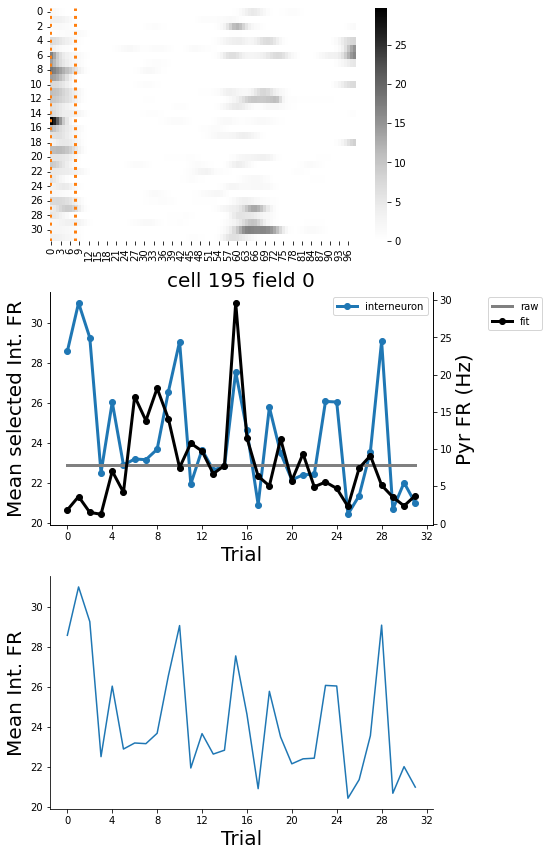

In [43]:
import peer_prediction as pp
reload(pp)
ti=0
# tt=0
tt='both'

per_field_metrics_one = per_field_metrics_all.loc[(ani,sess,ti),:]
# ma= (per_field_metrics_one.loc[tt,'fit_var_ratio']>0.7) & (per_field_metrics_one.loc[tt,'si']>1.)
ma= (per_field_metrics_one.loc[tt,'fit_var_ratio']>0.6) & (per_field_metrics_one.loc[tt,'si']>1.)
good_sw=per_field_metrics_one.loc[tt].loc[ma]
ii=1# 11
uid,field_id = good_sw.index[ii]                                                 
if tt=='both':
    spk_beh_df_onetask = spk_beh_df.loc[spk_beh_df['task_index']==ti]
else:
    spk_beh_df_onetask = spk_beh_df.loc[spk_beh_df['trial_type']==(ti,tt)]
uid_endog  = uid
cell_cols_exog = cell_cols_d['int']

if tt=='both':
    fr_map_trial_df_exog = fr_map_trial_df_bothtt_int.loc[ti]
else:
    fr_map_trial_df_exog = fr_map_trial_df_all_int.loc[(ti,tt),:]

# cell_cols_exog = [x for x in cell_cols_d['pyr'] if x!=uid]
# fr_map_trial_df_exog = fr_map_trial_df_all.loc[(ti,tt),:].drop(uid,level=0)

# cell_cols_exog = [x for x in cell_cols_d['all'] if x!=uid]
# fr_map_trial_df_exog = fr_map_trial_df_all_both.loc[(ti,tt),:].drop(uid,level=0)

all_sw_one_field = all_sw_with_metrics.loc[ti].query('trialtype==@tt&uid==@uid')
trials_to_exclude = all_sw_one_field['trial_index']

all_fields_one = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),:]
# glm_res, glm_res_df, pred_val, mean_within_field_pred = pp.fit_glm_predict_rate_change(spk_beh_df_onetask,uid_endog,cell_cols_exog,trials_to_exclude,
#                         fr_map_trial_df_exog,all_fields_one,model_type="linear",
#                         verbose=False)
alpha_l = [0.01,0.001,0.0001,0.00001,0.000001]
model_type = "linear"
do_weighted_pred = False
do_inh_only = False#True
do_exc_only = False
glm_res, glm_res_df, pred_val, mean_within_field_pred = pp.fit_glm_predict_rate_change(spk_beh_df_onetask,uid_endog,cell_cols_exog,trials_to_exclude,
                        fr_map_trial_df_exog,all_fields_one,model_type=model_type,alpha=alpha_l,
                        p_thresh=None,
                        do_inh_only = do_inh_only, do_exc_only=do_exc_only,                                                                                       
                        do_weighted_pred=do_weighted_pred,
                        verbose=False)


fr_map_one_tt_predictor = fr_map_trial_df_exog

if tt=='both':
    fr_map_trial_df_all_for_plot = fr_map_trial_df_bothtt_pyr
else:
    fr_map_trial_df_all_for_plot = fr_map_trial_df_all
    

reload(pp)
pp.post_fit_plot(pred_val,mean_within_field_pred,
            all_fields,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred
            )

# sweep through all fields

In [168]:
%%time
import peer_prediction as pp
reload(pp)
ti=0
do_inh_only = True
do_weighted_pred = False
pval_thresh=0.05
gpb = all_sw_with_metrics.loc[ti].groupby(['trialtype','uid','field_index'])
all_fields_one_sess = all_fields_recombined_all.loc[(ani,sess),:]

mean_within_field_pred_all = {}
r2_all = {}
for k,val in gpb:
    tt,uid,field_id = k
    glm_res, glm_res_df, pred_val, mean_within_field_pred = pp.fit_glm_predict_rate_change_wrapper(spk_beh_df,ti,tt,uid,field_id,cell_cols_d,
                                    fr_map_trial_df_bothtt_int,
                                    fr_map_trial_df_all_int,
                                    all_sw_with_metrics,all_fields_one_sess,
                                    do_inh_only=do_inh_only,
                                    do_weighted_pred = do_weighted_pred, 
                                    pval_thresh = pval_thresh,                                                                                                                             
                                    )
    if tt=='both':
        mean_within_field_pred.index=index_within_to_trial_index_df.loc[ti].sort_values().values
    else:
        mean_within_field_pred.index=index_within_to_trial_index_df.loc[ti,tt].index
        
    mean_within_field_pred_all[k] = mean_within_field_pred
    r2_all[k] = glm_res.rsquared

mean_within_field_pred_all = pd.concat(mean_within_field_pred_all,axis=0).unstack()
r2_all = pd.Series(r2_all)

<timed exec>:8: PerformanceWarning: indexing past lexsort depth may impact performance.


CPU times: user 45.6 s, sys: 26.3 s, total: 1min 11s
Wall time: 19.3 s


In [ ]:
## first, for each switch, how and how much does the connected inh fr change 

In [81]:
all_sw_with_metrics

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both   66            0  6684.468867    27.401026       25.0   
  1        both   67            0  6683.535300    30.506287        8.0   
  2        both  186            0  6684.402200    30.468344       24.0   
  3        both  329            0  6684.035433    40.542415       17.0   
  4        both  349            0  6684.035433    40.542415       17.0   
...         ...  ...          ...          ...          ...        ...   
  201       0.0  181            1  8222.942500    11.502441       43.0   
  202       0.0  204            0  8220.241800     8.558946       35.0   
  203       0.0  250            0  8242.805858    19.295595       83.0   
  204       0.0  313            1  8234.245367    15.980170       56.0   
  205       0.0  357            1  8223.709333    11.951551       49.0   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2     1.0             1           2.0  ...   
  1              2     1.0             1           2.0  ...   
  2              2     1.0             1           2.0  ...   
  3              2     1.0             1           2.0  ...   
  4              2     1.0             1           2.0  ...   
...            ...     ...           ...           ...  ...   
  201           30     1.0            18          18.0  ...   
  202           30     1.0            18          18.0  ...   
  203           30     1.0            18          18.0  ...   
  204           30     1.0            18          18.0  ...   
  205           30    -1.0            18          18.0  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                  0.0                            0.03125   
  1                                  0.0                            0.00000   
  2                                  0.0                            0.00000   
  3                                  0.0                            0.00000   
  4                                  0.0                            0.00000   
...                                  ...                                ...   
  201                                0.0                            0.00000   
  202                                0.0                            0.00000   
  203                                0.0                            0.00000   
  204                                0.0                            0.00000   
  205                                0.0                            0.10000   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.46875                            0.75000   
  1                              0.03125                            0.28125   
  2                              0.03125                            0.12500   
  3                              0.00000                            0.03125   
  4                              0.06250                            0.09375   
...                                  ...                                ...   
  201                            0.00000                            0.05000   
  202                            0.00000                            0.00000   
  203                            0.05000                            0.05000   
  204                            0.00000                            0.00000   
  205                            0.10000                            0.10000   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                               0.8750                            0.93750   
  1                               0.6250                            0.71875   
  2                               0.1875                            0.21875   
  3                               0.1250                            0.21875   
  4                               0.2500                           

In [118]:
change_in_inh_fr_allsw={}
per_field_metrics_allsw={}
for i, row in all_sw_with_metrics.loc[ti].iterrows():
    tt,uid,field_id=row['trialtype'],row['uid'],row['field_index']
    sw_tr = row['switch_trial']
    sw = row['switch']
    change_in_inh_fr=mean_within_field_pred_all.loc[tt,uid,field_id].loc[sw_tr] - mean_within_field_pred_all.loc[tt,uid,field_id].loc[sw_tr-1]
    change_in_inh_fr_allsw[i] = change_in_inh_fr
    per_field_metrics_one_sw = per_field_metrics_one.loc[(tt,uid,field_id),['fit_var_ratio','sparsity','mean']]
    per_field_metrics_allsw[i] = per_field_metrics_one_sw
change_in_inh_fr_allsw = pd.Series(change_in_inh_fr_allsw)
per_field_metrics_allsw = pd.concat(per_field_metrics_allsw,axis=0).unstack()
    

In [119]:
per_field_metrics_allsw

,fit_var_ratio,sparsity,mean
0,0.710373,1.265996,15.441749
1,0.542660,1.666003,19.180310
2,0.695016,1.629435,4.521723
3,0.578723,2.015310,20.125519
4,0.658906,2.851918,15.024616
...,...,...,...
201,0.638267,2.280955,2.517687
202,0.843652,4.206337,2.134234
203,0.789125,4.886189,2.604224
204,0.684256,3.843273,5.948275


In [120]:
all_sw_with_metrics_oneti_with_inh_change=copy.copy(all_sw_with_metrics.loc[ti])
all_sw_with_metrics_oneti_with_inh_change['inh_fr_change'] = change_in_inh_fr_allsw
all_sw_with_metrics_oneti_with_inh_change = pd.concat([all_sw_with_metrics_oneti_with_inh_change,per_field_metrics_allsw],axis=1)




In [121]:
all_sw_with_metrics_oneti_with_inh_change

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change,fit_var_ratio,sparsity,mean
0,both,66,0,6684.468867,27.401026,25.0,2,1.0,1,2.0,...,0.8750,0.93750,0.90625,0.46875,0.18750,0.06250,-1.077994,0.710373,1.265996,15.441749
1,both,67,0,6683.535300,30.506287,8.0,2,1.0,1,2.0,...,0.6250,0.71875,0.71875,0.68750,0.43750,0.09375,-0.764157,0.542660,1.666003,19.180310
2,both,186,0,6684.402200,30.468344,24.0,2,1.0,1,2.0,...,0.1875,0.21875,0.21875,0.18750,0.09375,0.03125,-0.727079,0.695016,1.629435,4.521723
3,both,329,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.1250,0.21875,0.21875,0.21875,0.18750,0.09375,-1.764463,0.578723,2.015310,20.125519
4,both,349,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.2500,0.31250,0.31250,0.25000,0.21875,0.06250,-1.740035,0.658906,2.851918,15.024616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,181,1,8222.942500,11.502441,43.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.05000,0.05000,1.796924,0.638267,2.280955,2.517687
202,0.0,204,0,8220.241800,8.558946,35.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,0.320355,0.843652,4.206337,2.134234
203,0.0,250,0,8242.805858,19.295595,83.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.05000,0.05000,0.05000,3.013733,0.789125,4.886189,2.604224
204,0.0,313,1,8234.245367,15.980170,56.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,1.424314,0.684256,3.843273,5.948275


In [91]:
all_sw_with_metrics_oneti_with_inh_change

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_30_perc_frac_total,post_ntrial_le_50_perc_frac_total,post_ntrial_le_70_perc_frac_total,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change
0,both,66,0,6684.468867,27.401026,25.0,2,1.0,1,2.0,...,0.03125,0.46875,0.75000,0.8750,0.93750,0.90625,0.46875,0.18750,0.06250,-1.077994
1,both,67,0,6683.535300,30.506287,8.0,2,1.0,1,2.0,...,0.00000,0.03125,0.28125,0.6250,0.71875,0.71875,0.68750,0.43750,0.09375,-0.764157
2,both,186,0,6684.402200,30.468344,24.0,2,1.0,1,2.0,...,0.00000,0.03125,0.12500,0.1875,0.21875,0.21875,0.18750,0.09375,0.03125,-0.727079
3,both,329,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.00000,0.00000,0.03125,0.1250,0.21875,0.21875,0.21875,0.18750,0.09375,-1.764463
4,both,349,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.00000,0.06250,0.09375,0.2500,0.31250,0.31250,0.25000,0.21875,0.06250,-1.740035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,181,1,8222.942500,11.502441,43.0,30,1.0,18,18.0,...,0.00000,0.00000,0.05000,0.0500,0.10000,0.10000,0.10000,0.05000,0.05000,1.796924
202,0.0,204,0,8220.241800,8.558946,35.0,30,1.0,18,18.0,...,0.00000,0.00000,0.00000,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,0.320355
203,0.0,250,0,8242.805858,19.295595,83.0,30,1.0,18,18.0,...,0.00000,0.05000,0.05000,0.0500,0.10000,0.10000,0.05000,0.05000,0.05000,3.013733
204,0.0,313,1,8234.245367,15.980170,56.0,30,1.0,18,18.0,...,0.00000,0.00000,0.00000,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,1.424314


In [125]:
scipy.stats.ranksums(all_sw_with_metrics_oneti_with_inh_change.query('switch==1&mean<2')['inh_fr_change'],
all_sw_with_metrics_oneti_with_inh_change.query('switch==-1&mean<2')['inh_fr_change'])

RanksumsResult(statistic=-0.6556100681071858, pvalue=0.5120750458379033)

<Axes: xlabel='switch', ylabel='inh_fr_change'>

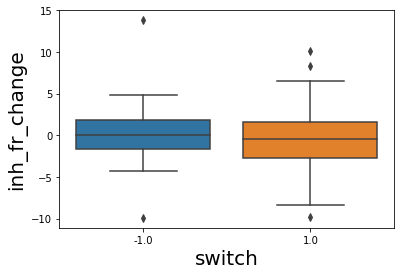

In [113]:
toplot=all_sw_with_metrics_oneti_with_inh_change.query('sparsity>3')
sns.boxplot(data=toplot,x='switch',y='inh_fr_change')
# all_sw_with_metrics_oneti_with_inh_change

<Axes: >

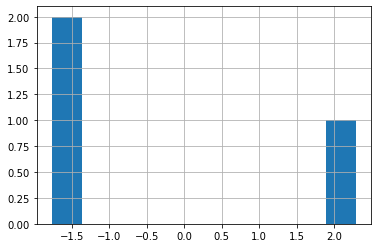

In [145]:
ma=(all_sw_with_metrics_oneti_with_inh_change_onesw['pre_ntrial_ge_10_perc_frac_total']<0.1)&(all_sw_with_metrics_oneti_with_inh_change_onesw['mean']>20)
all_sw_with_metrics_oneti_with_inh_change_onesw.loc[ma,'inh_fr_change'].hist()

## now look at the positive and negative cases of the inh_fr_change

In [220]:

all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==1')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# all_sw_with_metrics_oneti_with_inh_change_onesw.loc[inds].query('inh_fr_change<0')
ii=2
row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False).iloc[ii]
tt,uid,field_id = row[['trialtype','uid','field_index']]
r2 = r2_all.loc[tt,uid,field_id]
print(r2)

0.02982155192128466


In [221]:
row[['switch_trial','inh_fr_change']]

switch_trial          5.0
inh_fr_change    6.516108
Name: 42, dtype: object

(<Figure size 576x864 with 5 Axes>,
 array([<Axes: >,
        <Axes: title={'center': 'cell 120 field 0'}, xlabel='Trial', ylabel='Mean selected Int. FR'>,
        <Axes: xlabel='Trial', ylabel='Mean Int. FR'>], dtype=object))

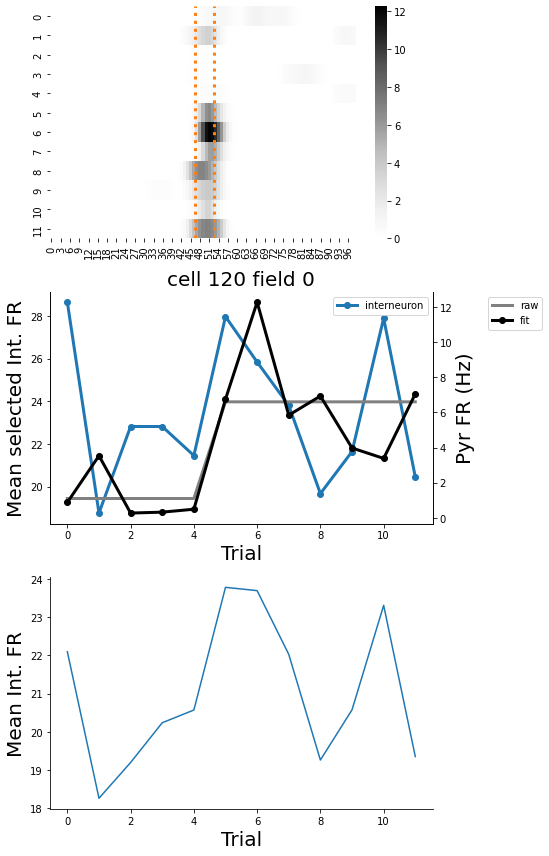

In [222]:
reload(pp)
if tt=='both':
        fr_map_trial_df_exog = fr_map_trial_df_bothtt_int.loc[ti]
else:
    fr_map_trial_df_exog = fr_map_trial_df_all_int.loc[(ti,tt),:]
fr_map_one_tt_predictor = fr_map_trial_df_exog

if tt=='both':
    fr_map_trial_df_all_for_plot = fr_map_trial_df_bothtt_pyr
else:
    fr_map_trial_df_all_for_plot = fr_map_trial_df_all
mean_within_field_pred = mean_within_field_pred_all.loc[tt,uid,field_id]


reload(pp)
pp.post_fit_plot(mean_within_field_pred,
            all_fields,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred
            )

In [149]:
tt

'both'

In [ ]:
all_sw_with_metrics_oneti_with_inh_change_onesw 

<Axes: xlabel='sparsity', ylabel='inh_fr_change'>

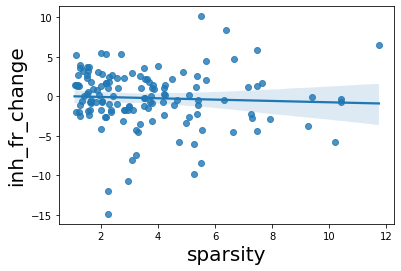

In [110]:
# sns.regplot(data=all_sw_with_metrics_oneti_with_inh_change_onesw,x='trial_index',y='inh_fr_change')
sns.regplot(data=all_sw_with_metrics_oneti_with_inh_change_onesw,x='sparsity',y='inh_fr_change')

In [188]:
# inhibiting_int_ind=glm_res_df.loc[glm_res_df['coef']<0].index
inhibiting_int_ind=glm_res_df.loc[(glm_res_df['coef']<0)&(glm_res_df['p']<0.05)].index

In [189]:
inhibiting_int_ind

Index([2, 5, 18, 25, 27, 29, 48, 53], dtype='object')

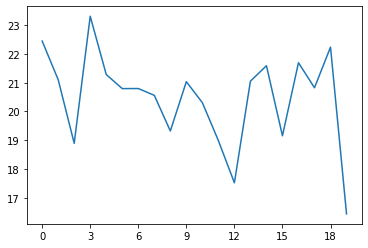

In [190]:
xx=fr_map_trial_df_all_int.loc[(ti,tt),:].loc[inhibiting_int_ind].loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0)
ax=xx.plot()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

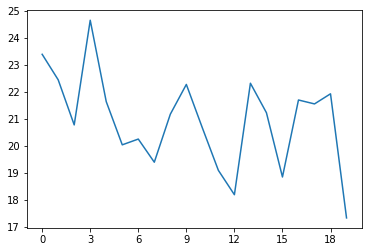

In [184]:
xx=fr_map_trial_df_all_int.loc[(ti,tt),:].loc[inhibiting_int_ind].loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0)
ax=xx.plot()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [173]:
fr_map_trial_df_all_int.loc[(ti,tt,inhibiting_int_ind),:].loc[(slice(None),slice(None),)]

0          1          2          3          4   \
0 0.0 2.0  0   49.955846  50.715169  32.953923  27.903427  26.511614   
           1   51.799572  49.833710  34.053474  25.570436  25.387655   
           2   54.618909  48.282059  35.706051  23.081519  23.913068   
           3   57.618314  46.364470  37.467928  21.381859  22.866439   
           4   60.545250  44.448426  39.148242  20.425726  22.580690   
...                  ...        ...        ...        ...        ...   
      58.0 94   3.128866   1.626112   1.525583   0.825099   0.988221   
           95   2.314425   1.405182   1.069737   0.314389   0.535626   
           96   1.484854   1.217684   0.885574   0.102019   0.252608   
           97   0.844247   1.072339   0.830993   0.028797   0.103665   
           98   0.510938   0.989413   0.820322   0.008497   0.044170   

                      5          6          7          8          9   \
0 0.0 2.0  0   36.140243  29.457028  49.755367  27.355042  35.533513   
           1   33.045273  29.825104  48.222438  26.265022  32.932122   
           2   28.745163  30.490174  45.857710  24.564484  29.258601   
           3   24.998608  31.391906  43.680935  23.037683  26.003638   
           4   22.530333  32.518021  42.667135  22.334265  23.798775   
...                  ...        ...        ...        ...        ...   
      58.0 94   1.160570   0.534432   3.010994   1.588790   0.738885   
           95   0.704693   0.774384   2.866279   1.774061   0.354183   
           96   0.342870   1.063562   2.770779   1.907057   0.142069   
           97   0.145774   1.332213   2.705497   1.943607   0.049309   
           98   0.069176   1.497671   2.666663   1.929712   0.017943   

                      10         11         12         13         14  \
0 0.0 2.0  0   29.860472  27.454300  33.929108  37.573007  20.598193   
           1   29.755985  25.398488  32.219301  36.591776  19.806263   
           2   29.667742  22.450295  29.760058  35.004830  19.002219   
           3   29.839441  19.724624  27.821171  33.294621  18.600935   
           4   30.699034  17.865091  27.368202  31.920821  18.692480   
...                  ...        ...        ...        ...        ...   
      58.0 94   3.027563   1.717258   1.763008   0.000000   0.657310   
           95   2.898333   2.351662   2.097431   0.000000   0.345384   
           96   2.842684   2.817179   2.379524   0.000000   0.154909   
           97   2.873586   3.090016   2.557861   0.000000   0.060738   
           98   2.928957   3.211638   2.640291   0.000000   0.025653   

                      15         16         17         18         19  
0 0.0 2.0  0   32.934285  53.701054  18.767729  13.245049  19.191251  
           1   31.479697  52.732636  18.387246  12.996104  19.618201  
           2   29.063785  50.576697  18.201558  12.951548  20.080477  
           3   26.571014  47.064431  18.494385  13.304387  20.430668  
           4   24.911979  42.642240  19.162747  14.000130  20.712835  
...                  ...        ...        ...        ...        ...  
      58.0 94   1.253509   3.136784   0.008219   0.631575   1.582594  
           95   1.331494   3.921282   0.001807   0.312215   1.599243  
           96   1.440981   4.511450   0.000000   0.129960   1.583559  
           97   1.519174   4.857506   0.000000   0.046240   1.556675  
           98   1.555487   5.010988   0.000000   0.016826   1.537080  

[1584 rows x 20 columns]

In [13]:
ti=0
tt=0
per_field_metrics_one = per_field_metrics_all.loc[(ani,sess,ti),:]
ma= (per_field_metrics_one.loc[tt,'fit_var_ratio']>0.7) & (per_field_metrics_one.loc[tt,'si']>1.)
good_sw=per_field_metrics_one.loc[tt].loc[ma]
ii=16
uid,field_id = good_sw.index[ii]                                                 

/tmp/ipykernel_711414/2235412756.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess,ti),:]


(<Figure size 432x288 with 2 Axes>, <Axes: >)

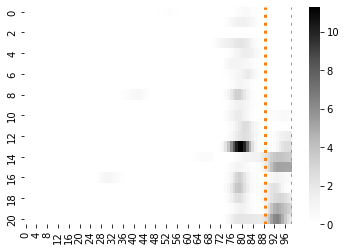

In [14]:
fr_map_trial_one = fr_map_trial_df_all.loc[ti,tt,uid].T
field_bound=all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
fig,ax=None,None
ph.ratemap_one_raw(fr_map_trial_one,trial=None,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})




In [17]:
all_sw_one_field = all_sw_with_metrics.loc[ti].query('trialtype==@tt&uid==@uid')

trials_to_exclude = all_sw_one_field['trial_index']

In [20]:
spk_beh_df_onetask=spk_beh_df.loc[spk_beh_df['trial_type']==(ti,tt)]
ma=np.logical_not(spk_beh_df_onetask['trial'].isin(trials_to_exclude))
# ma=spk_beh_df_onetask['trial'].isin(trials_to_exclude)
spk_beh_df_onetask_trialexcluded=spk_beh_df_onetask.loc[ma]
# cell_cols_d['int']

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
y=spk_beh_df_onetask_trialexcluded[uid].values

X = spk_beh_df_onetask_trialexcluded[cell_cols_d['int']]
x_cols = X.columns
X = X.values
X = sm.add_constant(X)


In [151]:
# from sklearn.linear_model import LassoCV
# alphas = [0.001,0.0005,0.0001,0.00005]
# reg = LassoCV(cv=10, alphas=alphas,random_state=2).fit(X, y)

# reg.alpha_

In [24]:
# res=sm.OLS(y,X).fit()

# res.summary()

In [25]:
glm_res=sm.genmod.GLM(y,X,family=sm.families.Poisson()).fit()

glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                33824
Model:                            GLM   Df Residuals:                    33780
Model Family:                 Poisson   Df Model:                           43
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -888.16
Date:                Sat, 02 Sep 2023   Deviance:                       1464.3
Time:                        19:52:53   Pearson chi2:                 4.13e+04
No. Iterations:                     9   Pseudo R-squ. (CS):           0.009659
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6150      0.250    -26.443      0.000      -7.105      -6.125
x1             0.0392      0.086      0.456      0.649      -0.129       0.208
x2            -0.1390      0.083     -1.675      0.094      -0.302       0.024
x3             0.2361      0.074      3.203      0.001       0.092       0.381
x4            -0.1239      0.084     -1.481      0.139      -0.288       0.040
x5            -0.1627      0.086     -1.889      0.059      -0.332       0.006
x6             0.1589      0.060      2.644      0.008       0.041       0.277
x7             0.0550      0.065      0.845      0.398      -0.073       0.183
x8             0.0607      0.087      0.698      0.485      -0.110       0.231
x9             0.2028      0.059      3.446      0.001       0.087       0.318
x10           -0.0520      0.086     -0.603      0.547      -0.221       0.117
x11           -0.0891      0.081     -1.095      0.274      -0.249       0.070
x12           -0.0762      0.088     -0.868      0.385      -0.248       0.096
x13            0.0471      0.077      0.615      0.539      -0.103       0.197
x14            0.3689      0.074      4.978      0.000       0.224       0.514
x15            0.2427      0.074      3.260      0.001       0.097       0.389
x16            0.3214      0.084      3.837      0.000       0.157       0.486
x17           -0.2535      0.128     -1.986      0.047      -0.504      -0.003
x18           -0.3849      0.081     -4.735      0.000      -0.544      -0.226
x19            0.1482      0.077      1.929      0.054      -0.002       0.299
x20            0.2604      0.094      2.775      0.006       0.076       0.444
x21            0.3502      0.074      4.764      0.000       0.206       0.494
x22            0.1467      0.101      1.451      0.147      -0.051       0.345
x23            0.2744      0.104      2.639      0.008       0.071       0.478
x24            0.0877      0.109      0.806      0.420      -0.126       0.301
x25           -0.2403      0.119     -2.021      0.043      -0.473      -0.007
x26            0.0797      0.239      0.333      0.739      -0.389       0.548
x27           -0.4583      0.237     -1.937      0.053      -0.922       0.006
x28           -0.1089      0.165     -0.660      0.510      -0.433       0.215
x29           -0.5546      0.278     -1.996      0.046      -1.099      -0.010
x30            0.6402      0.201      3.181      0.001       0.246       1.035
x31           -0.0980      0.086     -1.139      0.255      -0.267       0.071
x32           -0.1672      0.104     -1.606      0.108      -0.371       0.037
x33            0.0742      0.077      0.966      0.334      -0.076       0.225
x34           -0.2251      0.099     -2.269      0.023      -0.420      -0.031
x35           -0.1232      0.113     -1.090      0.276      -0.345       0.098
x3

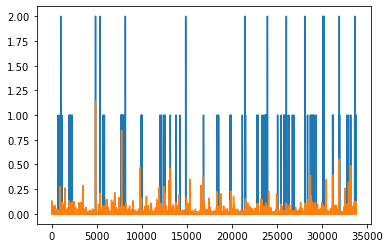

In [26]:
y_hat=glm_res.predict(X)
fig,ax=plt.subplots()
ax.plot(y)
ax.plot(y_hat)

In [27]:
glm_res_df=pd.DataFrame([glm_res.params,glm_res.pvalues],index=['coef','p'])
glm_res_df = glm_res_df.iloc[:,1:]
glm_res_df.columns=x_cols
glm_res_df = glm_res_df.T

In [28]:
pval_ma = (glm_res_df['p']<0.05).values.astype(float)

In [30]:
ti=0
fr_map_trial_df_int_or_pyr = fr_map_trial_df_all_int
fr_map_one_tt_predictor = fr_map_trial_df_int_or_pyr.loc[ti,tt]
fr_map_one_tt_predictor_tr_pos_stacked=fr_map_one_tt_predictor.unstack(level=1)

pred_val = glm_res_df['coef'].values.dot(fr_map_one_tt_predictor_tr_pos_stacked)

# pred_val = (glm_res_df['coef'].values * pval_ma).dot(fr_map_one_tt_predictor_tr_pos_stacked * pval_ma[:,None])

pred_val = pd.Series(pred_val,index=fr_map_one_tt_predictor_tr_pos_stacked.columns)
pred_val=pred_val.unstack()

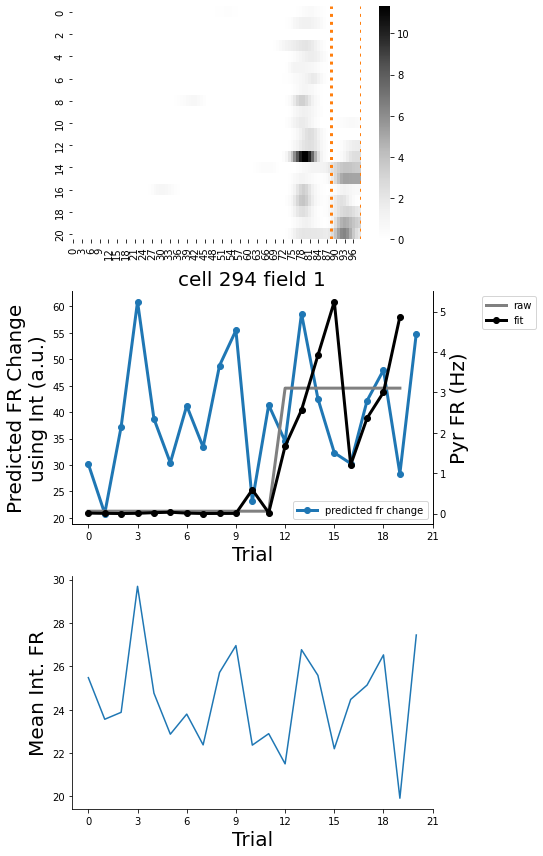

In [44]:
from matplotlib.ticker import MaxNLocator

st,ed=all_fields.loc[ti,tt,uid,field_id][['start','end']].values
mean_within_field_pred = pred_val.loc[:,st:ed].mean(axis=1)

fig,axs=plt.subplots(3,1,figsize=(8,12))

ax=axs[0]
fr_map_trial_one = fr_map_trial_df_all.loc[ti,tt,uid].T
field_bound=all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

ph.ratemap_one_raw(fr_map_trial_one,trial=None,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})



ax=axs[1]
mean_within_field_pred.plot(ax=ax,label='predicted fr change',linewidth=3,marker='o')
ax2=ax.twinx()
ax2.plot(X_pwc.loc[ti,tt,uid,field_id].dropna().values,c='grey',label='raw',linewidth=3)
ax2.plot(X_raw.loc[ti,tt,uid,field_id].dropna().values,c='black',label='fit',marker='o',linewidth=3)
sns.despine(top=True,right=False,ax=ax)
sns.despine(top=True,right=False,ax=ax2)
ax.legend()
ax2.legend(bbox_to_anchor=[1.3,1])
ax.set(ylabel='Predicted FR Change\nusing Int (a.u.)',xlabel='Trial')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set(ylabel='Pyr FR (Hz)')
ax.set_title(f'cell {uid} field {field_id}')

ax=axs[2]
sns.despine(ax=ax)
fr_map_one_tt_predictor.groupby(level=1).mean().loc[st:ed].mean(axis=0).plot(ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Trial',ylabel='Mean Int. FR')

plt.tight_layout()

<Axes: >

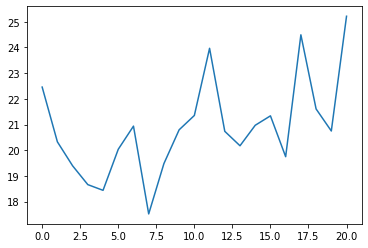

In [496]:
# int population


start    45
end      53
Name: (0, 0.0, 183, 0), dtype: object

<Axes: >

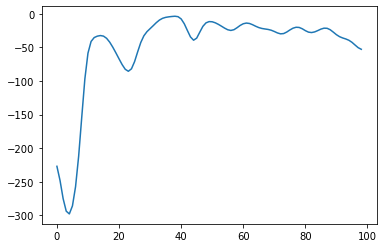

In [339]:
pred_val.loc[0].plot()

<Axes: >

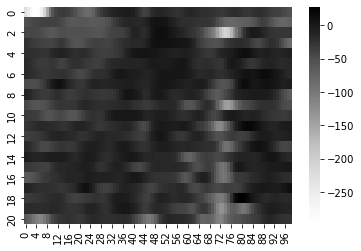

In [335]:
sns.heatmap(data=pred_val,cmap='Greys')

In [329]:
fr_map_one_tt_predictor_tr_pos_stacked

0                                                          \
              0          1          2          3          4          5    
1.0    43.717552  43.591698  43.842502  44.929191  47.007519  49.997643   
2.0    49.955846  51.799572  54.618909  57.618314  60.545250  63.524060   
3.0    48.592724  50.355795  52.881487  55.288315  57.365855  59.382749   
4.0    82.378503  84.894782  88.445229  91.539466  93.344099  93.303814   
5.0    45.829445  47.300195  49.361294  51.177532  52.418471  53.131967   
6.0    42.514133  44.046411  46.364616  48.693411  50.550150  51.548184   
7.0    61.842381  60.923678  59.609356  58.419246  57.641267  57.495812   
8.0    36.225362  35.587067  34.773607  34.203863  34.010848  34.138942   
9.0    36.762756  33.930358  29.725941  25.531354  21.917433  18.963138   
10.0   38.498962  39.090484  39.949141  40.750921  41.308750  41.466783   
11.0   29.419714  29.166525  29.050911  29.482669  30.715951  32.911872   
12.0   40.604160  39.953567  39.106441  38.487867  38.286747  38.597246   
13.0   51.607578  50.336013  48.762358  47.811351  47.862003  48.876760   
14.0   42.543831  45.629133  50.204433  54.792893  58.886887  62.670810   
15.0   35.447264  34.666254  33.649855  32.926333  32.746172  33.197021   
16.0   37.503704  36.538968  35.311225  34.482547  34.311370  34.761558   
17.0   10.952754  11.242657  11.645797  11.991546  12.196759  12.211608   
18.0   31.772715  30.874725  29.574672  28.312499  27.189177  26.029499   
19.0   22.993050  24.684942  27.346252  30.352670  33.587822  37.297890   
20.0   27.693703  26.681234  25.419776  24.608367  24.482854  24.949889   
21.0   29.477812  29.413899  29.298072  29.120179  28.821183  28.269216   
22.0   23.326175  23.203238  23.103949  23.151126  23.352286  23.593572   
23.0   29.063946  28.565997  27.956502  27.611340  27.709997  28.309150   
24.0   15.495426  15.908179  16.555399  17.290380  18.101712  19.080855   
25.0   18.422392  18.084884  17.600969  17.121544  16.640665  16.030908   
26.0    5.841458   5.967384   6.096452   6.109817   5.955448   5.638218   
27.0    2.176803   2.676619   3.496793   4.457093   5.459088   6.439571   
28.0   11.474647  12.716473  14.623595  16.651160  18.585556  20.425746   
29.0    0.907015   1.065590   1.313238   1.584891   1.858282   2.148044   
30.0    1.823441   1.513865   1.077724   0.685828   0.402387   0.220542   
45.0   35.566187  36.522022  38.014370  39.652664  41.288415  42.918371   
46.0   27.185819  26.743385  26.084852  25.436340  24.918123  24.596504   
47.0   22.513297  21.813176  20.947370  20.403750  20.338392  20.661578   
48.0   38.311719  37.758291  37.038020  36.541028  36.473557  36.927664   
49.0   17.094343  18.068432  19.380777  20.419685  20.908847  20.778194   
50.0   29.209539  29.017623  28.979849  29.415794  30.438260  31.992891   
51.0    7.624962   7.841343   8.044242   8.021363   7.698058   7.104650   
52.0   10.886429  11.277183  11.918183  12.687277  13.546416  14.473424   
53.0    4.350902   4.744552   5.220981   5.488651   5.432225   5.051882   
58.0    2.254610   2.520814   2.909996   3.307157   3.710018   4.203496   
69.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
109.0   1.298644   1.562499   1.970777   2.400265   2.778230   3.053672   
205.0   9.818902  10.778181  11.974328  12.722264  12.732135  11.959892   

                                                   ...         20             \
              6          7          8          9   ...         89         90   
1.0    53.596108  57.071296  59.069076  58.374877  ...  39.129948  46.766962   
2.0    66.758367  70.176744  72.938837  73.456133  ...  40.743284  37.249511   
3.0    61.744493  64.584750  67.132152  67.655962  ...  69.540749  73.009134   
4.0    90.624329  84.189648  73.584408  61.185154  ...  37.232911  37.947122   
5.0    53.599146  54.345052  56.030164  58.759252  ...  41.156734  39.458759   
6.0    51.105318  48.373039  42.865460  35.985600  ...  52.866449  50.713631  

In [331]:
glm_res_df['coef'].values.dot(fr_map_one_tt_predictor_tr_pos_stacked)

array([-226.92159625, -247.97042573, -275.01460427, ...,  -24.98455542,
        -25.9454054 ,  -26.4892867 ])

In [317]:
fr_map_one_tt_int

lin_binned,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
1.0,35.088503,34.347529,33.250465,32.125000,31.169624,30.554293,30.437322,30.903776,31.875911,33.078140,...,27.932258,30.308335,33.028189,35.887170,38.714164,41.218570,43.079896,44.154507,44.575903,44.657879
2.0,33.416827,32.450989,31.077905,29.860281,29.190133,29.364184,30.604229,32.951714,36.076366,39.239120,...,32.075433,28.950182,26.318536,24.634899,24.231198,25.219806,27.271853,29.720212,31.833521,33.039433
3.0,34.209716,34.268714,34.509673,34.939666,35.535639,36.345966,37.511436,39.167095,41.254642,43.455129,...,50.433155,50.989594,50.820285,50.118018,48.976074,47.493084,45.910219,44.475400,43.381280,42.784280
4.0,43.154127,42.746551,42.106151,41.335270,40.457593,39.529180,38.611657,37.644747,36.474564,35.096008,...,28.923500,29.322942,30.463734,31.965078,33.544117,34.957424,36.037365,36.776231,37.224647,37.430881
5.0,43.351837,43.937245,45.050677,46.634525,48.666380,51.136071,53.965677,56.911287,59.464231,60.912747,...,44.474706,43.970822,43.639160,43.676207,44.082110,44.647446,45.172021,45.605472,45.939231,46.127026
6.0,50.271800,50.731216,51.323016,51.745224,51.751880,51.148257,49.827059,47.759651,45.056028,42.173995,...,44.006918,43.108122,42.618849,42.775491,43.618770,45.003328,46.604665,48.041706,49.026411,49.488869
7.0,67.146043,65.657269,63.794152,62.147935,60.830290,59.977411,59.884935,60.900134,63.241282,66.720346,...,60.740349,59.417060,58.880390,59.266812,60.605596,62.744822,65.331834,67.852548,69.814207,70.877211
8.0,30.675096,30.203207,29.621432,29.184731,28.945288,28.948114,29.357103,30.278463,31.506996,32.673038,...,25.580488,26.125310,26.620661,27.207393,28.107556,29.505895,31.409299,33.529251,35.363775,36.423155
9.0,35.805209,35.303281,34.352306,33.097794,31.647180,30.058956,28.348085,26.501831,24.594163,22.793965,...,38.879448,41.138386,42.824957,43.762292,44.142470,44.226729,44.165179,44.030190,43.878631,43.777317
10.0,29.068114,28.794115,28.453582,28.307336,28.545540,29.303465,30.635281,32.449906,34.482447,36.326831,...,28.392934,30.516668,32.162999,33.545101,34.906646,36.305578,37.659552,38.858266,39.764967,40.252419


In [311]:
glm_res_df

,coef,p
1,-0.402415,6.127637e-03
2,0.353583,8.502723e-04
3,0.527919,1.974709e-08
4,-0.149196,2.420245e-01
5,-0.215850,6.170188e-02
6,-0.472847,3.771297e-06
7,0.262711,2.986054e-03
8,0.492936,1.549395e-05
9,0.307704,2.037228e-05
10,0.166444,1.330529e-01


In [303]:
glm_res_df = pd.DataFrame(glm_res.summary().tables[1])
glm_res_df.index=glm_res_df[0].values
glm_res_df.columns=['','coef','se','z','p','ci_low','ci_high']
glm_res_df = glm_res_df.iloc[2:,1:]
glm_res_df.index= x_cols
glm_res_df = glm_res_df.astype(float)



TypeError: float() argument must be a string or a number, not 'Cell'

In [302]:
glm_res_df

,coef,se,z,p,ci_low,ci_high
1,-0.4024,0.147,-2.741,0.006,-0.690,-0.115
2,0.3536,0.106,3.336,0.001,0.146,0.561
3,0.5279,0.094,5.614,0.000,0.344,0.712
4,-0.1492,0.128,-1.170,0.242,-0.399,0.101
5,-0.2158,0.116,-1.868,0.062,-0.442,0.011
6,-0.4728,0.102,-4.624,0.000,-0.673,-0.272
7,0.2627,0.088,2.969,0.003,0.089,0.436
8,0.4929,0.114,4.322,0.000,0.269,0.716
9,0.3077,0.072,4.261,0.000,0.166,0.449
10,0.1664,0.111,1.502,0.133,-0.051,0.384


In [301]:
glm_res_df.loc[glm_res_df['p']<0.05]

TypeError: '<' not supported between instances of 'Cell' and 'float'

In [298]:
glm_res_df

,coef,se,z,p,ci_low,ci_high
1,-0.4024,0.147,-2.741,0.006,-0.690,-0.115
2,0.3536,0.106,3.336,0.001,0.146,0.561
3,0.5279,0.094,5.614,0.000,0.344,0.712
4,-0.1492,0.128,-1.170,0.242,-0.399,0.101
5,-0.2158,0.116,-1.868,0.062,-0.442,0.011
6,-0.4728,0.102,-4.624,0.000,-0.673,-0.272
7,0.2627,0.088,2.969,0.003,0.089,0.436
8,0.4929,0.114,4.322,0.000,0.269,0.716
9,0.3077,0.072,4.261,0.000,0.166,0.449
10,0.1664,0.111,1.502,0.133,-0.051,0.384


In [269]:
glm_res.pvalues<0.05

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False,  True, False,  True, False, False, False,
       False, False,  True,  True, False,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False,  True,  True, False, False, False, False, False])

In [267]:
coef_sig = glm_res.params[glm_res.pvalues<0.05][1:]

In [268]:
coef_sig

array([-0.40241475,  0.35358278,  0.52791851, -0.47284715,  0.26271112,
        0.49293611,  0.3077044 , -0.23343903, -0.32795509, -0.68124815,
        0.4946607 ,  0.34858685,  1.1789636 , -0.30894147, -0.34152285,
       -0.50067032, -1.25430231])

(32, 1)

# switch triggered population vector

In [12]:
sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
if sw_info_res is None:
    sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)

all_sw_with_metrics = sw_info_res['all_sw_with_metrics_d']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---


In [26]:
ti=0
tt=0
index_within = 1
pos = 25
fr_map_trial_df_all_int.loc[(ti,tt,slice(None),pos),index_within]

0  0.0  1.0    25    46.047403
        2.0    25    29.280855
        3.0    25    31.592027
        4.0    25    48.257000
        5.0    25    43.041289
        6.0    25    44.293429
        7.0    25    78.854398
        8.0    25    31.716732
        9.0    25    10.294318
        10.0   25    23.704451
        11.0   25    48.093309
        12.0   25    43.492023
        13.0   25    56.951566
        14.0   25    37.673923
        15.0   25    54.417307
        16.0   25    60.531647
        17.0   25    17.074582
        18.0   25    19.284066
        19.0   25    12.477922
        20.0   25    16.040684
        21.0   25    12.193989
        22.0   25    22.443748
        23.0   25    23.083486
        24.0   25     8.928135
        25.0   25    19.407915
        26.0   25     4.593519
        27.0   25     4.712473
        28.0   25    14.115766
        29.0   25     1.576783
        30.0   25     1.173651
        45.0   25    34.289622
        46.0   25    27.227445
        

In [28]:
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)

In [32]:
trial_index_to_index_within_df

   tt_ind  trial_ind
0  0.0     0.0           0
           2.0           1
           4.0           2
           6.0           3
           11.0          4
           12.0          5
           13.0          6
           15.0          7
           17.0          8
           18.0          9
           20.0         10
           21.0         11
           23.0         12
           24.0         13
           26.0         14
           27.0         15
           28.0         16
           29.0         17
           30.0         18
           31.0         19
   1.0     1.0           0
           3.0           1
           5.0           2
           7.0           3
           8.0           4
           9.0           5
           10.0          6
           14.0          7
           16.0          8
           19.0          9
           22.0         10
           25.0         11
Name: index, dtype: int64

In [34]:
trial_index_to_index_within_df.loc[ti,slice(None),row['trial_index']]

tt_ind
0.0    18
Name: index, dtype: int64

In [61]:
ti=0
fr_map_trial_df_int_or_pyr = fr_map_trial_df_all_int

pop_vec_d = {}
for ii,row in all_sw_with_metrics.iterrows():
    xx=trial_index_to_index_within_df.loc[ti,slice(None),row['trial_index']]
    tt = xx.index[0]
    index_within = xx.values[0]
    pos = row['field_pos']
    pop_vec = fr_map_trial_df_int_or_pyr.loc[(ti,tt,slice(None),pos),index_within].droplevel([0,1,3])
    pop_vec_d[ii] = pop_vec
pop_vec_d = pd.concat(pop_vec_d,axis=1).T
unit_cols = pop_vec_d.columns
pop_vec_df = pd.concat([pop_vec_d,all_sw_with_metrics],axis=1)

In [ ]:
# include negative examples


In [136]:
all_sw_with_metrics.loc[ti].groupby(['trial_index','field_pos']).count()

trialtype  uid  field_index  time  speed_gauss  switch  \
trial_index field_pos                                                           
2           8.0                1    1            1     1            1       1   
            17.0               2    2            2     2            2       2   
            24.0               1    1            1     1            1       1   
            25.0               1    1            1     1            1       1   
3           3.0                1    1            1     1            1       1   
...                          ...  ...          ...   ...          ...     ...   
30          76.0               1    1            1     1            1       1   
            80.0               1    1            1     1            1       1   
            83.0               1    1            1     1            1       1   
            84.0               1    1            1     1            1       1   
            91.0               1    1            1     1            1       1   

                       index_within  switch_trial  switch_trial_frac  \
trial_index field_pos                                                  
2           8.0                   1             1                  1   
            17.0                  2             2                  2   
            24.0                  1             1                  1   
            25.0                  1             1                  1   
3           3.0                   1             1                  1   
...                             ...           ...                ...   
30          76.0                  1             1                  1   
            80.0                  1             1                  1   
            83.0                  1             1                  1   
            84.0                  1             1                  1   
            91.0                  1             1                  1   

                       pre_ntrials_in_segment  ...  \
trial_index field_pos                          ...   
2           8.0                             1  ...   
            17.0                            2  ...   
            24.0                            1  ...   
            25.0                            1  ...   
3           3.0                             1  ...   
...                                       ...  ...   
30          76.0                            1  ...   
            80.0                            1  ...   
            83.0                            1  ...   
            84.0                            1  ...   
            91.0                            1  ...   

                       post_ntrial_le_10_perc_frac_total  \
trial_index field_pos                                      
2           8.0                                        1   
            17.0                                       2   
            24.0                                       1   
            25.0                                       1   
3           3.0                                        1   
...                                                  ...   
30          76.0                                       1   
            80.0                                       1   
            83.0                                       1   
            84.0                                       1   
            91.0                                       1   

                       post_ntrial_le_30_perc_frac_total  \
trial_index field_pos                                      
2           8.0                                        1   
            17.0                                       2   
            24.0                                       1   
            25.0                                       1   
3           3.0                                        1   
...                                                  ...   
30          76.0                                       1   
        

In [69]:
X = pop_vec_df[unit_cols].values.T

In [70]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)

In [75]:
W = pca.fit_transform(X)
H = pca.components_

In [83]:
pop_vec_df['switch']

0  0      1.0
   1      1.0
   2      1.0
   3      1.0
   4      1.0
         ... 
   201    1.0
   202    1.0
   203    1.0
   204    1.0
   205   -1.0
Name: switch, Length: 206, dtype: float64

In [87]:
import matplotlib.colors as mcolors

In [95]:
c_l

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.273809, 0.031497, 0.358853, 1.      ],
       [0.276022, 0.044167, 0.370164, 1.      ],
       [0.278791, 0.062145, 0.386592, 1.      ],
       [0.280894, 0.078907, 0.402329, 1.      ],
       [0.28291 , 0.105393, 0.426902, 1.      ],
       [0.283197, 0.11568 , 0.436115, 1.      ],
       [0.283072, 0.130895, 0.449241, 1.      ],
       [0.28229 , 0.145912, 0.46151 , 1.      ],
       [0.279574, 0.170599, 0.479997, 1.      ],
       [0.278012, 0.180367, 0.486697, 1.      ],
       [0.275191, 0.194905, 0.496005, 1.      ],
       [0.269308, 0.218818, 0.509577, 1.      ],
       [0.265145, 0.232956, 0.516599, 1.      ],
       [0.260571, 0.246922, 0.522828, 1.      ],
       [0.257322, 0.25613 , 0.526563, 1.      ],
       [0.243113, 0.292092, 0.538516, 1.      ],
       [0.237441, 0.305202, 0.541921, 1.      ],
       [0.233603, 0.313828, 0.543914, 1.      ],
       [0.227802, 0.326594, 0.546532, 1.      ],
       [0.223925, 0.

In [103]:
all_sw_with_metrics.columns

Index(['trialtype', 'uid', 'field_index', 'time', 'speed_gauss', 'field_pos',
       'trial_index', 'switch', 'index_within', 'switch_trial',
       'switch_trial_frac', 'pre_ntrials_in_segment',
       'post_ntrials_in_segment', 'pre_mean_fr_1', 'pre_mean_fr_2',
       'pre_mean_fr_3', 'pre_mean_fr_all', 'post_mean_fr_1', 'post_mean_fr_2',
       'post_mean_fr_3', 'post_mean_fr_all', 'pre_mean_fr_1_norm',
       'pre_mean_fr_2_norm', 'pre_mean_fr_3_norm', 'pre_mean_fr_all_norm',
       'post_mean_fr_1_norm', 'post_mean_fr_2_norm', 'post_mean_fr_3_norm',
       'post_mean_fr_all_norm', 'pre_ntrial_le_10_perc',
       'pre_ntrial_le_30_perc', 'pre_ntrial_le_50_perc',
       'pre_ntrial_le_70_perc', 'pre_ntrial_le_90_perc',
       'pre_ntrial_ge_10_perc', 'pre_ntrial_ge_30_perc',
       'pre_ntrial_ge_50_perc', 'pre_ntrial_ge_70_perc',
       'pre_ntrial_ge_90_perc', 'post_ntrial_le_10_perc',
       'post_ntrial_le_30_perc', 'post_ntrial_le_50_perc',
       'post_ntrial_le_70_perc', 'pos

Text(0.5, 1.0, 'colored by speed_gauss')

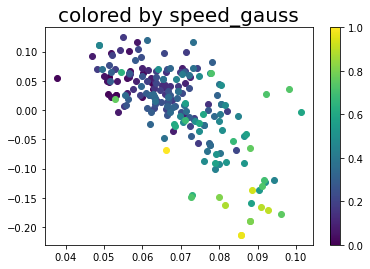

In [139]:
fig,ax=plt.subplots()
# sw_l = [1,-1]
key = 'speed_gauss'#'pre_ntrial_le_30_perc_frac_segment'#'switch'
key_val_l = np.unique(pop_vec_df[key])
key_val_l=key_val_l[~np.isnan(key_val_l)]
norm = mcolors.Normalize(vmin=key_val_l.min(), vmax=key_val_l.max())
normalized_values = norm(key_val_l)
c_l = plt.cm.viridis(normalized_values)
for ii,vv in enumerate(key_val_l):
    ma = np.isclose(pop_vec_df[key],vv)
    sc=ax.scatter(H[0][ma],H[1][ma],c=c_l[[ii]])
plt.colorbar(sc)
ax.set_title(f"colored by {key}")

In [123]:
pca.explained_variance_ratio_

array([0.83890822, 0.03295631])

In [79]:
H.shape

(2, 206)

In [47]:
pop_vec

1.0      33.017411
2.0      19.630474
3.0      37.521147
4.0      20.974934
5.0      32.102005
6.0      37.543372
7.0      70.536047
8.0      15.862270
9.0      35.496220
10.0     19.553614
11.0     34.077795
12.0     28.864940
13.0     38.721259
14.0     30.430020
15.0     46.956309
16.0     29.308058
17.0     14.603799
18.0     48.706672
19.0     18.620142
20.0      9.725645
21.0     19.303842
22.0     28.737237
23.0     14.385949
24.0     12.572700
25.0     18.677090
26.0      1.831601
27.0      6.450363
28.0      5.613827
29.0      2.361141
30.0      0.244310
45.0     18.674037
46.0     17.638525
47.0     20.729435
48.0     26.464564
49.0     13.027246
50.0     14.417562
51.0     16.983397
52.0      1.382289
53.0      6.464365
58.0      0.194246
69.0      1.697235
109.0     2.282030
205.0     0.000000
Name: 18, dtype: float64

In [43]:
pos

25

In [17]:
all_sw_with_metrics

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both   66            0  6684.468867    27.401026       25.0   
  1        both   67            0  6683.535300    30.506287        8.0   
  2        both  186            0  6684.402200    30.468344       24.0   
  3        both  329            0  6684.035433    40.542415       17.0   
  4        both  349            0  6684.035433    40.542415       17.0   
...         ...  ...          ...          ...          ...        ...   
  201       0.0  181            1  8222.942500    11.502441       43.0   
  202       0.0  204            0  8220.241800     8.558946       35.0   
  203       0.0  250            0  8242.805858    19.295595       83.0   
  204       0.0  313            1  8234.245367    15.980170       56.0   
  205       0.0  357            1  8223.709333    11.951551       49.0   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2     1.0             1           2.0  ...   
  1              2     1.0             1           2.0  ...   
  2              2     1.0             1           2.0  ...   
  3              2     1.0             1           2.0  ...   
  4              2     1.0             1           2.0  ...   
...            ...     ...           ...           ...  ...   
  201           30     1.0            18          18.0  ...   
  202           30     1.0            18          18.0  ...   
  203           30     1.0            18          18.0  ...   
  204           30     1.0            18          18.0  ...   
  205           30    -1.0            18          18.0  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                  0.0                            0.03125   
  1                                  0.0                            0.00000   
  2                                  0.0                            0.00000   
  3                                  0.0                            0.00000   
  4                                  0.0                            0.00000   
...                                  ...                                ...   
  201                                0.0                            0.00000   
  202                                0.0                            0.00000   
  203                                0.0                            0.00000   
  204                                0.0                            0.00000   
  205                                0.0                            0.10000   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.46875                            0.75000   
  1                              0.03125                            0.28125   
  2                              0.03125                            0.12500   
  3                              0.00000                            0.03125   
  4                              0.06250                            0.09375   
...                                  ...                                ...   
  201                            0.00000                            0.05000   
  202                            0.00000                            0.00000   
  203                            0.05000                            0.05000   
  204                            0.00000                            0.00000   
  205                            0.10000                            0.10000   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                               0.8750                            0.93750   
  1                               0.6250                            0.71875   
  2                               0.1875                            0.21875   
  3                               0.1250                            0.21875   
  4                               0.2500                           

# side track, E-I 

In [188]:
ti = 0
pyr_active_map=(fr_map_df_all.loc[ti].dropna(axis=1,how='all') > 1).mean(axis=0)

In [189]:
sess

'e13_16f1_210328'

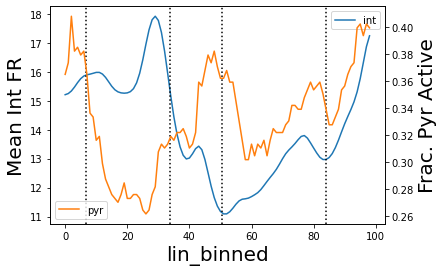

In [190]:
fig,ax=plt.subplots()
fr_map_df_all_int.loc[ti].mean(axis=0).plot(ax=ax,label='int')
ax2=ax.twinx()
ax2.set(ylabel='Frac. Pyr Active')
ax.set(ylabel='Mean Int FR')
pyr_active_map.plot(ax=ax2,label='pyr',color='C1')
ax.legend()
ax2.legend()

# lines = 
lines_d = {0:np.array([15,74,111,185])/2.2,1:np.array([50,85,135])/2.2}
for l in lines_d[ti]:
    ax.axvline(l,color='k',linestyle=':')

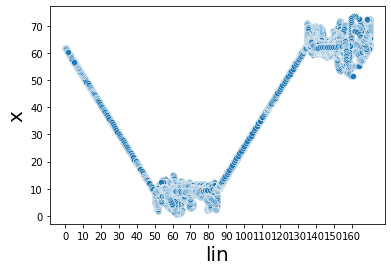

In [179]:
beh=spk_beh_df.query('task_index==1')
ax=sns.scatterplot(data=beh,x='lin',y='x')
# ax=sns.scatterplot(data=beh,x='lin',y='y')
_=ax.set_xticks(np.arange(0,beh['lin'].max(),10))



<Axes: xlabel='lin_binned'>

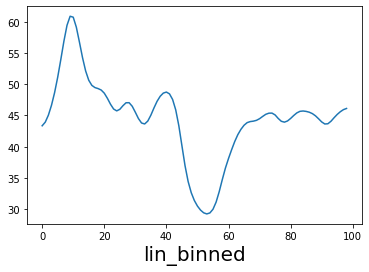

In [43]:
fr_map_df_all_int.loc[0,0,5].plot()

In [18]:
cell_cols_d['int']

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  58.,  69., 109., 205.])